# Solution To Fraud Detection challenge

In this notebook we have the work that I have done to analyze the data as well apply machine learning algorithms in order to create a fraud detection system for the vendor. Note that I shall be using Pandas and Scikit-learn heavily. In case there is some confusion about a partcular method, please feel free to ask for clarifications

## 1.0 Loading data and Creating Pandas Data Frame  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Reading csv file and storing as dataframe

In [2]:
df_original=pd.read_csv("Fraud_Data.csv",header=0)

Printing out first 5 entries to see what things look like

In [3]:
df_original.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


Printing out relative amounts of the two classes and printing out some statistics for each class using the pandas describe() function

In [4]:
print "Class proportions"
df_original["class"].value_counts().values/float(np.sum(df_original["class"].value_counts().values))

Class proportions


array([ 0.90635423,  0.09364577])

Statistics for purchase Price

In [5]:
for i in range(2):
    print "Statistics for class ",i
    print df_original[df_original["class"]==i].purchase_value.describe()
    print 

Statistics for class  0
count    136961.000000
mean         36.929418
std          18.315064
min           9.000000
25%          22.000000
50%          35.000000
75%          49.000000
max         154.000000
Name: purchase_value, dtype: float64

Statistics for class  1
count    14151.000000
mean        36.993004
std         18.397654
min          9.000000
25%         22.000000
50%         35.000000
75%         49.000000
max        111.000000
Name: purchase_value, dtype: float64



Now we shall define some functions to create Histograms and KDE functions for any particular column of the dataframe

In [6]:
def plot_hist(field_name,bins=50):
    args={"legend":True,"figsize":(8,8),"kind":"hist","title":"Probability Distribition for "+field_name,"bins":bins}
    df_original[field_name][df_original["class"]==0].plot(label="Not Fraud",**args)
    df_original[field_name][df_original["class"]==1].plot(label="Fraud",**args)
    
def plot_kde(field_name):
    args={"legend":True,"figsize":(8,8),"kind":"kde","title":"Probability Distribition for "+field_name}
    df_original[field_name][df_original["class"]==0].plot(label="Not Fraud",**args)
    df_original[field_name][df_original["class"]==1].plot(label="Fraud",**args)    

Example output for Purchase value field. Now from this KDE function we can see that the Fraud and Non-Fraud classes have very similar distributions for Purchase value. This tells us that purchase price might not be a great column to look at for classification purchases. The Fraud class is peaked at a slightly lower value though, which might be useful later.

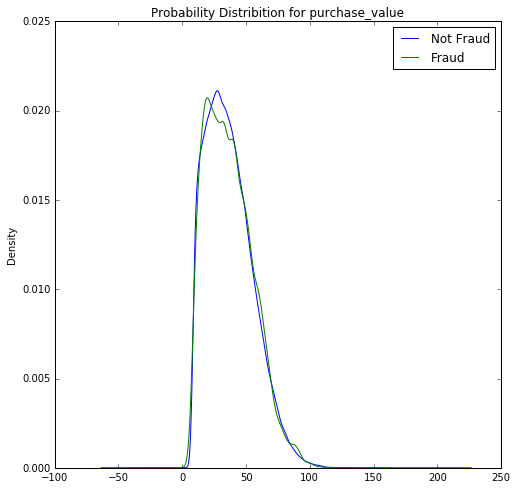

In [7]:
plot_kde("purchase_value")

Now we get on to the problem of mapping the IP address to a country. We first read the csv file and store it with the lower bound as the index (this will help us in mapping later)  

In [8]:
df_ip_add=pd.read_csv("IpAddress_to_Country.csv",index_col=0)
df_ip_add.head()

,upper_bound_ip_address,country
lower_bound_ip_address,,
16777216.0,16777471,Australia
16777472.0,16777727,China
16777728.0,16778239,China
16778240.0,16779263,Australia
16779264.0,16781311,China


Now we we use the ip adress in the original data frame to get the country. We do this by finding the index of the ip_address dataframe which is immediately before (by using the pad keyword) the ip address we pass to the function below. Since we used the lower bound as the index, we get back the row with the correct ip address. Then we just return the country for that particular row. Note that some of the entries in the dataframe were throwing errors, because the elements we not in the list below, so we had to use exception handling and return "No Value" for those values . 

In [9]:
def get_country(x):
    try:
        return df_ip_add.iloc[df_ip_add.index.get_loc(np.round(x),method='pad')]["country"]
    except:
        
        return "No value"

Now we apply this function to the ip_address column and store it as a new column "Country"

In [10]:
df_original["Country"]=df_original["ip_address"].apply(get_country)

"Country" will now be a categorical variable with 182 values. This kind of categorical variable is hard to handle. So I decided to bin the countries in terms of frequency of occurance. The most frequent to least frequent countries are put in bins 0 to 2 , with the "No value" entries put in bin -1. The threshholds for the bins are 10,000, 500 and 0. I tried other binnings as well and found that it does not really change things.  

In [11]:
country_val_count=df_original[df_original["Country"].notnull()]["Country"].value_counts()

In [61]:
def frequency_mask(x):
    if x=='No value':
        return -1
    if country_val_count[x]> 10000:
        return 0
    elif country_val_count[x] >500:
        return 1
    else:
        return 2
    

Using this binning function to create the binned Country colun called "Country_mask"

In [62]:
df_original["Country_mask"]=df_original["Country"].apply(frequency_mask)

Checking bins formed and also the most common countries 

In [63]:
print df_original["Country_mask"].value_counts()
df_original["Country"].value_counts().head()

 0    92488
 1    47013
 2    10977
-1      634
Name: Country_mask, dtype: int64


United States     59222
Australia         21228
China             12038
Japan              7918
United Kingdom     4492
Name: Country, dtype: int64

Label Encoding the other categorical variables such as Source , browser and sex

In [16]:
from sklearn.preprocessing import LabelEncoder

In [17]:
Le_source=LabelEncoder()
Le_source.fit(df_original["source"].values)
df_original["Source_Encoded"]=Le_source.transform(df_original["source"].values)

In [18]:
Le_browser=LabelEncoder()
Le_browser.fit(df_original["browser"].values)
df_original["browser_encoded"]=Le_browser.transform(df_original["browser"].values)

In [19]:
Le_sex=LabelEncoder()
Le_sex.fit(df_original["sex"].values)
df_original["sex_encoded"]=Le_sex.transform(df_original["sex"].values)

Now we come to the problem of how to use the device_id field . It struck me that fraudsters would probably be reusing the same device and making a lot purchases. So we I decided to mark the use count for each individual device id. This is stroed in the column "device use frequency"

In [20]:
freq_use_dict=df_original["device_id"].value_counts()
df_original["device use frequency"]=df_original["device_id"].apply(lambda x: freq_use_dict[x])

The only other columns which need parsing are the signup time and purchase time. Again it struck me that if I were a fraudster I would not really create an account a long time before I purchased things. Therefore I decided to create a new variable called "hours_to_purchase" which calculates the number of hours passed between signup and purchase.  

Note that we do not do anything to the user_id because it is unique for every entry and therefore not useful.In fact if you pass the user id column to a massive Decision tree it would probably create singletons by splitting on it, which is pointless because it will not be useful on test data. Ofcourse there are ways to get around this by using Information gain ratio or by pruning it intelligently, but that is besides the point.

In [21]:
df_original["hours_to_purchase"]=\
((pd.to_datetime(df_original["purchase_time"])-pd.to_datetime(df_original["signup_time"]))).astype('timedelta64[s]')/3600

Let us now look at the DataFrame created 

In [22]:
df_original.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,Country,Country_mask,Source_Encoded,browser_encoded,sex_encoded,device use frequency,hours_to_purchase
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,1,2,0,1,1,1251.856111
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,0,0,0,0,1,4.984444
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,0,2,3,1,12,0.000278
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,Australia,0,2,4,1,1,136.690278
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,0,0,4,1,1,1211.516944


In [260]:
df_original.to_csv("Saved_df.df")

Now we define a function to give us back relative class proportions for categorical variables. This shall help us in choosing which variables to use for classification

In [258]:
def get_relative_amounts(field_name):
    print "(Class Name)", "(Count)", "(Relative Probability of the Class)"
    for i in sorted(df_original[field_name].unique()) :
        print "For type {0}".format(i) 
        amt= df_original[df_original[field_name]==i]["class"].value_counts()
        for i in range(2):
            i,amt.get(i,0),float(amt.get(i,0))/np.sum(amt.values)

Checking Proprtions for the "source" field, we see that it is rather non-descriptive as the relative class proportions are rather similar for all values of the field

In [401]:
get_relative_amounts("source")

(Class Name) (Count) (Relative Probability of the Class)
For type Ads
0 54368 0.907934069237
1 5513 0.0920659307627
For type Direct
0 27390 0.894630258688
1 3226 0.105369741312
For type SEO
0 55203 0.910715169512
1 5412 0.0892848304875


Checking Proprtions for the "Country_mask" field, we see that the low frequency countries have a slightly higher proportion of frauds. This might be interesting to classify things, but the margins are rather disappointingly low. Note that I tested this by created more and different sized bins and things did not drastically improve

In [64]:
get_relative_amounts("Country_mask")

For type -1
572 0.902208201893
62 0.0977917981073
For type 0
83970 0.907901565609
8518 0.0920984343915
For type 1
42652 0.907238423415
4361 0.0927615765852
For type 2
9767 0.889769518083
1210 0.110230481917


We also present the histogram for this field

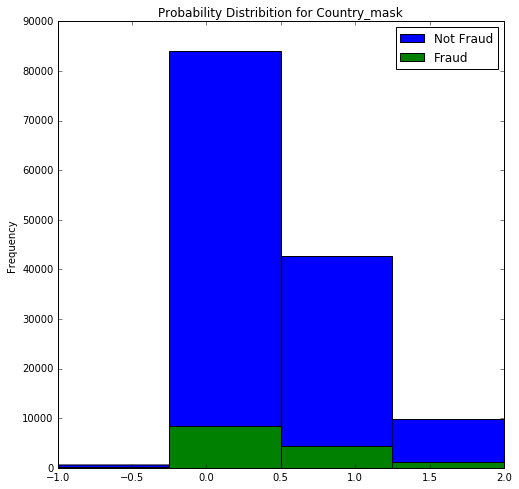

In [65]:
plot_hist("Country_mask",4)

Let us look at the field age. Again we see that the fields are very similar for both classes 

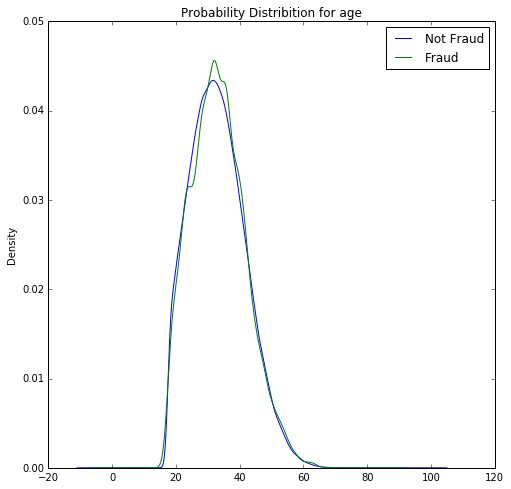

In [28]:
plot_kde("age")

Now let us see how the device use frequency Impacts things. As We can see below, the fraud probability goes up markedly for high use frequencies! This would make this a great variable to look at.

In [261]:
get_relative_amounts("device use frequency")

(Class Name) (Count) (Relative Probability of the Class)
For type 1
0 127771 0.969570727191
1 4010 0.0304292728087
For type 2
0 8214 0.770978036418
1 2440 0.229021963582
For type 3
0 204 0.755555555556
1 66 0.244444444444
For type 4
0 6 0.375
1 10 0.625
For type 5
0 13 0.2
1 52 0.8
For type 6
0 30 0.172413793103
1 144 0.827586206897
For type 7
0 49 0.14
1 301 0.86
For type 8
0 69 0.125
1 483 0.875
For type 9
0 78 0.111111111111
1 624 0.888888888889
For type 10
0 93 0.101086956522
1 827 0.898913043478
For type 11
0 102 0.0918091809181
1 1009 0.908190819082
For type 12
0 88 0.0814814814815
1 992 0.918518518519
For type 13
0 65 0.078125
1 767 0.921875
For type 14
0 58 0.0726817042607
1 740 0.927318295739
For type 15
0 47 0.0764227642276
1 568 0.923577235772
For type 16
0 38 0.0659722222222
1 538 0.934027777778
For type 17
0 14 0.0633484162896
1 207 0.93665158371
For type 18
0 11 0.0611111111111
1 169 0.938888888889
For type 19
0 5 0.0526315789474
1 90 0.947368421053
For type 20
0 6 0.05
1

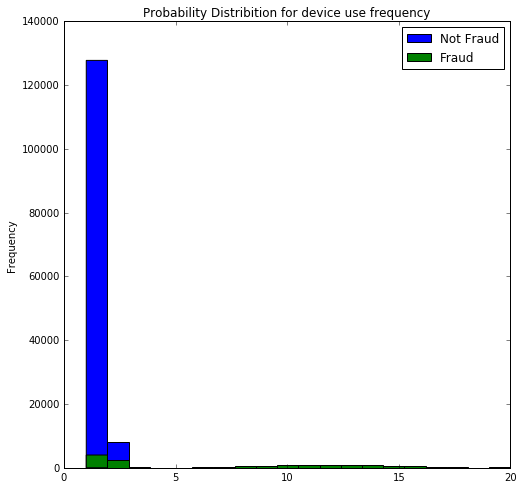

In [368]:
plot_hist("device use frequency",20)

Now let us see how the hours to purchase Impacts things. As we can see below, the distribution for frauds shows a huge spike at low times, whereas the non-fraud one does not! This would make this a great variable to look at.

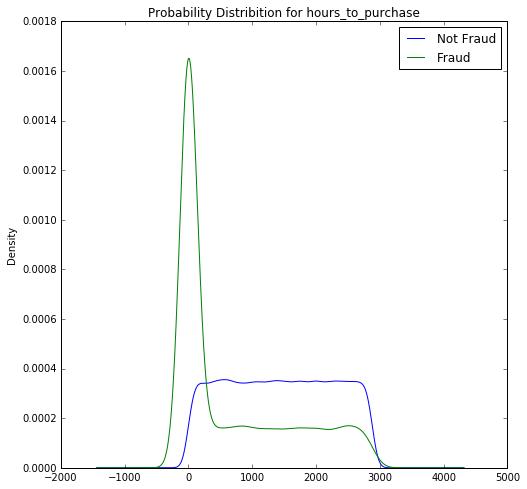

In [367]:
plot_kde("hours_to_purchase")

We also define a variable called hrs/use which is the quotient of the two good variables we have found so far. This might lead to better segregation. However as we see later, this didn't work out so well.

In [33]:
df_original["hrs/use"]=df_original["hours_to_purchase"]/df_original["device use frequency"]

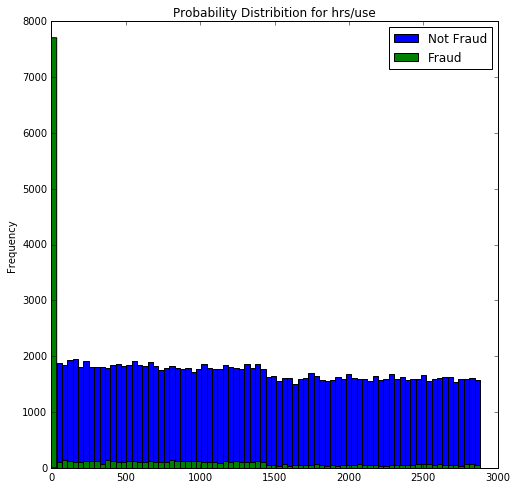

In [34]:
plot_hist("hrs/use",80)

We next present relative amounts for variables such as browser,sex and source. As we can see, there is not much differentiation here. However if you look through the data, you can see that a fraudulent user accesses using the same age, browser,purchase amount etc. So it might be useful to build up a identifier for a particular user if he uses the same device Id and the same values for these categorical variables. However for the purposes of this part of the excercise, we shall just leave it after encoding the categorical variables. We do some of this encoding in a future section of the notebook where we do this excercise in a more real-time setting (More on this later...)

In [37]:
get_relative_amounts("browser")

For type Chrome
55363 0.901207839562
6069 0.0987921604376
For type FireFox
22268 0.904835432751
2342 0.0951645672491
For type IE
33540 0.913224603153
3187 0.086775396847
For type Opera
3348 0.91077257889
328 0.0892274211099
For type Safari
22442 0.909798516236
2225 0.0902014837637


In [369]:
get_relative_amounts("sex")

(Class Name) (Count) (Relative Probability of the Class)
For type F
0 57102 0.908992502268
1 5717 0.0910074977316
For type M
0 79859 0.904477138618
1 8434 0.095522861382


In [370]:
get_relative_amounts("source")

(Class Name) (Count) (Relative Probability of the Class)
For type Ads
0 54368 0.907934069237
1 5513 0.0920659307627
For type Direct
0 27390 0.894630258688
1 3226 0.105369741312
For type SEO
0 55203 0.910715169512
1 5412 0.0892848304875


An example histogram for the encoded browser values

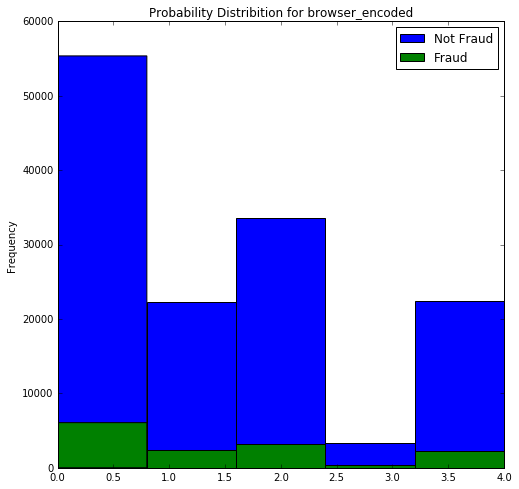

In [40]:
plot_hist("browser_encoded",5)

# Creating df for machine learning

Now we shall move on to the machine learning part of the excercise. First we start off by retaining only the numerical fields from the original dataframe, which might be useful to the algorithms.

In [66]:
to_keep=["Country_mask","device use frequency","Source_Encoded","browser_encoded","sex_encoded","hours_to_purchase","age","purchase_value","hrs/use","class"]
df_ml=df_original[to_keep]

Here is what we retained

In [67]:
df_ml.head()

,Country_mask,device use frequency,Source_Encoded,browser_encoded,sex_encoded,hours_to_purchase,age,purchase_value,hrs/use,class
0,1,1,2,0,1,1251.856111,39,34,1251.856111,0
1,0,1,0,0,0,4.984444,53,16,4.984444,0
2,0,12,2,3,1,0.000278,53,15,0.000023,1
3,0,1,2,4,1,136.690278,41,44,136.690278,0
4,0,1,0,4,1,1211.516944,45,39,1211.516944,0


# Lets start with logistic regression

Let us start off with the old faithful, Logistic Regression. First off we load some packages from sklearn. We will be using GridsearchCV to to optimize out classifier over hyperparameters by using K-Fold cross-validation. We will also be using a pipeline because we want to see what effects Standard Scaling has on our classifer. Finally we will also be using the train_test module to create training and test sets

In [68]:
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split

Lets start with the most promising fields-hours to purchase,country mask(maybe?) and device use frequency. We convert the values in the pandas dataframe to a numpy array because that is what sklearn likes. Note that there is a pandas+sklearn library as well which can do things directly on dataframes. However I do not have that installed so we will be converting to numpy arrays using the values member variable of a pandas series.

In [69]:
to_keep_ml=["device use frequency","hours_to_purchase","Country_mask"]
x_array=df_ml[to_keep_ml].values
y_array=df_ml["class"]

Here we see that the X (feature set) and Y( target) have the correct shapes

In [70]:
x_array.shape,y_array.shape

((151112, 3), (151112,))

Now we use Train Test Split to split the data in training and test sets. Note that we use a test set that is a quarter of the actual data set. We use Stratified split, which maintains the relative proportions in the two sets. We also fix the random state as we want to get some reproducibilty when we redo this step in the future

In [71]:
Train_X,Test_X,Train_Y,Test_y=train_test_split(x_array,y_array,test_size=0.25,stratify=y_array,random_state=42)

Checking the class proportions of the Test set. I did this to basically check that the stratified splitting  worked as expected 

In [72]:
from collections import Counter
Counter(Train_Y)

Counter({0: 102721, 1: 10613})

Now we use Pipeline to set up a pipeline using standard scaler and Logistic regression. Note that we again set the random state and later we shall also test whether Standard scaler being on/off works better.

In [73]:
Pipe_Lr=Pipeline([("Scaler",StandardScaler()),("LR",LogisticRegression(random_state=84))])

We choose a list to create the list of regularization parameters for the regularization parameter in log series. 

In [122]:
List_C=np.logspace(-5,5,11)
print List_C

[  1.00000000e-05   1.00000000e-04   1.00000000e-03   1.00000000e-02
   1.00000000e-01   1.00000000e+00   1.00000000e+01   1.00000000e+02
   1.00000000e+03   1.00000000e+04   1.00000000e+05]


Now we get to the parameter grid. If you have used spark.ml library in python, this should be familiar. Basically we create a parameter grid for different hyperparameters. Note that when we define the PipeLine, the different steps are given names (LR for Logistic Regression) in the tuples we define. Then we can specify a hyperparameter by using the syntax name__hyperparameter={Dictionary of values}.

Note that on my macbook air due to limited resources, I cannot do a single gridsearch over all possible things I want to search over as the process takes too long and I have to wait a long time without having any idea what is going on. Therefore in the pipelines in this book you see in this book from here on, you will see small grids. I however have tried many many more combinations by refining the search many times over. What you see has been attained after many other things were tried (in most cases)

Now let us get to the things we see here. The "with_std" parameter for scaler decides if we want to normalize to an std of 1.  The C I have already spoken about (regularization parameter). The penalty parameter decides whether to use L2 or L1 regularization.The most important parameter is the class weight. Now we want to over-represent the fraud class because we want that to be predicted correctly. The higher the weight, the more the classifier prioritizes it. Note sklearn also has a "balanced" mode which sets class weights to inverse of the occurance frequencies. 



In [107]:
Param_grid_Lr={"Scaler__with_std"
               :[True,False],"LR__C":List_C,"LR__penalty":['l1','l2'],\
               "LR__class_weight":["balanced",{0:1,1:1},{0:1,1:2},{0:1,1:5}]}

In this step we now use the grid search cross validation to optimize our classifier. We perform 4 fold stratified cross validation and use the F1 score of the fraud class as our optimization parameter. We choose this because right now this seems like a reasonable tradeoff between precision and recall (optimizing either one completely would lead to almost dummy classifiers in the extreme limit).

We then use the best classifer to fit to the training set and compute metrics on the test set.

In [108]:
best_Lr=GridSearchCV(Pipe_Lr,Param_grid_Lr,cv=4,verbose=1,n_jobs=1,scoring='f1')

In [109]:
best_Lr.fit(Train_X,Train_Y)


Fitting 4 folds for each of 80 candidates, totalling 320 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    7.9s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:   37.1s
[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:  1.1min finished


GridSearchCV(cv=4, error_score='raise',
       estimator=Pipeline(steps=[('Scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('LR', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=84, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'LR__penalty': ['l1', 'l2'], 'LR__class_weight': ['balanced', {0: 1, 1: 1}, {0: 1, 1: 2}, {0: 1, 1: 5}], 'Scaler__with_std': [True, False], 'LR__C': array([  1.00000e-04,   1.77828e-03,   3.16228e-02,   5.62341e-01,
         1.00000e+01])},
       pre_dispatch='2*n_jobs', refit=True, scoring='f1', verbose=1)

In [110]:
best_Lr.best_params_,best_Lr.best_score_

({'LR__C': 0.0001,
  'LR__class_weight': {0: 1, 1: 2},
  'LR__penalty': 'l2',
  'Scaler__with_std': True},
 0.6788541029786227)

In [ ]:
chosen_Lr=best_Lr.best_estimator_

chosen_Lr.fit(Train_X,Train_Y)
choser_Lr_train=chosen_Lr.predict(Train_X)

In [100]:
from sklearn.metrics import classification_report

We now output the precision and recall and f1 scores for the training set to see how we did on the training set. As we see our recall is very low while our precision is high, which means we have too "Bold" a classifier. 

In [398]:
print classification_report(Train_Y,choser_Lr_train)

             precision    recall  f1-score   support

          0       0.95      0.99      0.97    102721
          1       0.91      0.54      0.68     10613

avg / total       0.95      0.95      0.95    113334



We now output the coefficients of the logisitic regression classifier for the three fields. As we see , the hours to purchase (1st coefficient) and the use frequency (second coefficient) have significant values while country mask seems like a redundant parameter as expected.  The signs also make sense because of the depencies of frauds on these two variables (positive correlation and negative correlation respectively)

In [114]:
chosen_Lr.named_steps["LR"].coef_

array([[ 0.75454053, -0.13821351,  0.00183236]])

Checking metrics on the Test set. We see that we almost get the same metrics as the training set. Which means that we did not overfit.

In [399]:

choser_Lr_test=chosen_Lr.predict(Test_X)
print classification_report(Test_y,choser_Lr_test)

             precision    recall  f1-score   support

          0       0.95      0.99      0.97     34240
          1       0.91      0.53      0.67      3538

avg / total       0.95      0.95      0.94     37778



Now we compute the ROC curve and the ROC AUC score for this classifier. We get an AUC score of around 0.83 which is rather reasonable since we have taken rather few features.

In [116]:
from sklearn.metrics import roc_curve,auc

AUC for Logistic Regression=0.828716838675


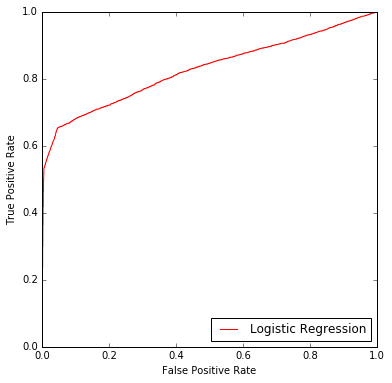

In [117]:
y_dec_func=chosen_Lr.decision_function(Test_X)
fpr_lr,tpr_lr,thresholds_log=roc_curve(Test_y,y_dec_func)

print "AUC for Logistic Regression={}".format(auc(fpr_lr,tpr_lr))

plt.figure(figsize=(6,6))
plt.plot(fpr_lr, tpr_lr,'r-',label="Logistic Regression")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc=4)

# Now optimizing for Roc AUC

We can also do the same thing but optimize for the ROC AUC score instead of the F1 score in GridsearchCV. With this setting we get a score of ~0.85 which is slightly better.

In [123]:
Param_grid_Lr={"Scaler__with_std":[True,False],"LR__C":List_C,"LR__penalty":['l1','l2'],"LR__class_weight":["balanced",{0:1,1:8},{0:1,1:6},{0:1,1:7}]}
best_Lr_roc=GridSearchCV(Pipe_Lr,Param_grid_Lr,cv=4,verbose=1,n_jobs=1,scoring='roc_auc')

In [124]:
best_Lr_roc.fit(Train_X,Train_Y)

Fitting 4 folds for each of 176 candidates, totalling 704 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    8.3s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:   35.1s
[Parallel(n_jobs=1)]: Done 449 tasks       | elapsed:  1.4min
[Parallel(n_jobs=1)]: Done 704 out of 704 | elapsed:  2.3min finished


GridSearchCV(cv=4, error_score='raise',
       estimator=Pipeline(steps=[('Scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('LR', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=84, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'LR__penalty': ['l1', 'l2'], 'LR__class_weight': ['balanced', {0: 1, 1: 8}, {0: 1, 1: 6}, {0: 1, 1: 7}], 'Scaler__with_std': [True, False], 'LR__C': array([  1.00000e-05,   1.00000e-04,   1.00000e-03,   1.00000e-02,
         1.00000e-01,   1.00000e+00,   1.00000e+01,   1.00000e+02,
         1.00000e+03,   1.00000e+04,   1.00000e+05])},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=1)

In [125]:
print best_Lr_roc.best_params_,best_Lr_roc.best_score_,
#print best_Lr_roc.grid_scores_

{'Scaler__with_std': False, 'LR__class_weight': {0: 1, 1: 8}, 'LR__penalty': 'l1', 'LR__C': 0.01} 0.841976077425


In [126]:
chosen_lr_roc=best_Lr_roc.best_estimator_

In [127]:
chosen_lr_roc.fit(Train_X,Train_Y)
choser_lr_train_roc=chosen_lr_roc.predict(Train_X)
choser_lr_test_roc=chosen_lr_roc.predict(Test_X)

In [402]:
print classification_report(Train_Y,choser_lr_train_roc,)

             precision    recall  f1-score   support

          0       0.95      0.99      0.97    102721
          1       0.89      0.55      0.68     10613

avg / total       0.95      0.95      0.95    113334



In [129]:
chosen_lr_roc.named_steps["LR"].coef_

array([[  9.31418647e-01,   6.18750322e-06,  -3.43849046e-04]])

AUC for Logistic Regression=0.844834066253


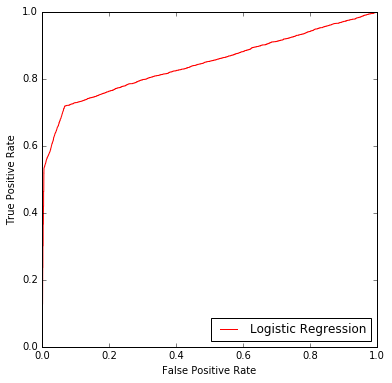

In [130]:
y_dec_func_roc=chosen_lr_roc.decision_function(Test_X)
fpr_lr_roc,tpr_lr_roc,thresholds_log_roc=roc_curve(Test_y,y_dec_func_roc)

print "AUC for Logistic Regression={}".format(auc(fpr_lr_roc,tpr_lr_roc))

plt.figure(figsize=(6,6))
plt.plot(fpr_lr_roc, tpr_lr_roc,'r-',label="Logistic Regression")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc=4)


# Trying out Random Forests

Now we shall try out Random Forests to try and do the exact same thing. I shall not go into all the details again as they are exact copies of what we did for Logistic Regression except the classifier is now different. (There are ofcourse technicalities we can talk about at length when we discuss things).

In [131]:
from sklearn.ensemble import RandomForestClassifier

In [132]:
Pipe_Rf=Pipeline([("Scaler",StandardScaler()),("Rf",RandomForestClassifier())])
Param_grid_Rf={"Scaler__with_std":[True],'Rf__n_estimators':[30],'Rf__min_samples_split':[650],\
                  'Rf__max_features':['auto',1,2,None],'Rf__class_weight':[{0:1,1:1}]}
best_Rf=GridSearchCV(Pipe_Rf,Param_grid_Rf,cv=4,verbose=1,n_jobs=1,scoring='f1')
best_Rf.fit(Train_X,Train_Y)
print best_Rf.best_params_,best_Rf.best_score_,


Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:  1.8min finished


{'Scaler__with_std': True, 'Rf__min_samples_split': 650, 'Rf__n_estimators': 30, 'Rf__class_weight': {0: 1, 1: 1}, 'Rf__max_features': 1} 0.70044586982


In [133]:
chosen_Rf=best_Rf.best_estimator_
chosen_Rf.fit(Train_X,Train_Y)
chosen_Rf_train=chosen_Rf.predict(Train_X)
chosen_Rf_test=chosen_Rf.predict(Test_X)

In [400]:
print classification_report(Test_y,chosen_Rf_test)

             precision    recall  f1-score   support

          0       0.95      1.00      0.98     34240
          1       1.00      0.53      0.69      3538

avg / total       0.96      0.96      0.95     37778



In [135]:
chosen_Rf.named_steps["Rf"].feature_importances_

array([  4.19190783e-01,   5.80358719e-01,   4.50497953e-04])

In [137]:
print classification_report(chosen_Rf_train,Train_Y)

             precision    recall  f1-score   support

          0       1.00      0.95      0.98    107611
          1       0.54      1.00      0.70      5723

avg / total       0.98      0.96      0.96    113334



AUC for Random Forest=0.843860916095


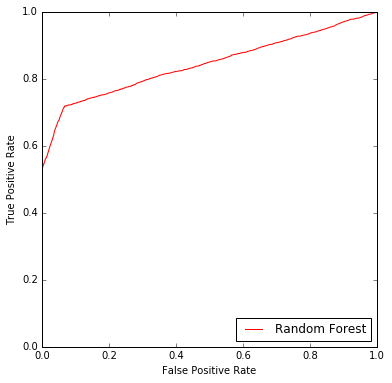

In [138]:
y_dec_func_Rf=chosen_Rf.predict_proba(Test_X)[:,1]
fpr_Rf,tpr_Rf,thresholds_Rf=roc_curve(Test_y,y_dec_func_Rf)

print "AUC for Random Forest={}".format(auc(fpr_Rf,tpr_Rf))

plt.figure(figsize=(6,6))
plt.plot(fpr_Rf, tpr_Rf,'r-',label="Random Forest")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc=4)


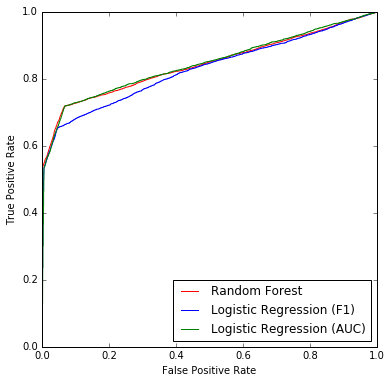

In [139]:
plt.figure(figsize=(6,6))
plt.plot(fpr_Rf, tpr_Rf,'r-',label="Random Forest")
plt.plot(fpr_lr, tpr_lr,'b-',label="Logistic Regression (F1)")
plt.plot(fpr_lr_roc, tpr_lr_roc,'g-',label="Logistic Regression (AUC)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc=4)


So we see that Random forest actually does reasonably well for ROC AUC score even though we optimize for f1. We get an F1 score of around ~0.7 and an ROC of 0.85

# Optimizing Random Forest for ROC AUC


I also Tried to optimize for roc-auc score for random forests.  The results were not much different. 

In [140]:
Pipe_Rf_roc=Pipeline([("Scaler",StandardScaler()),("Rf",RandomForestClassifier())])
Param_grid_Rf_roc={"Scaler__with_std":[True],'Rf__n_estimators':[30],'Rf__min_samples_split':[650],\
                  'Rf__max_features':['auto',1,2],'Rf__class_weight':[{0:1,1:1},'balanced',{0:1,1:2}]}
best_Rf_roc=GridSearchCV(Pipe_Rf_roc,Param_grid_Rf_roc,cv=4,verbose=1,n_jobs=1,scoring='roc_auc')
best_Rf_roc.fit(Train_X,Train_Y)
print best_Rf_roc.best_params_,best_Rf_roc.best_score_,

Fitting 4 folds for each of 9 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  3.5min finished


{'Scaler__with_std': True, 'Rf__min_samples_split': 650, 'Rf__n_estimators': 30, 'Rf__class_weight': {0: 1, 1: 1}, 'Rf__max_features': 1} 0.845976596721


# Lets try using the Hrs/use field instead

In [141]:
to_keep_ml2=["hrs/use","Country_mask"]
x_array2=df_ml[to_keep_ml2].values
y_array2=df_ml["class"]

In [143]:
x_array2.shape,y_array2.shape

((151112, 2), (151112,))

In [144]:
Train_X2,Test_X2,Train_Y2,Test_y2=train_test_split(x_array2,y_array2,test_size=0.25,stratify=y_array2,random_state=42)

In [145]:
Param_grid_Lr={"Scaler__with_std"
               :[True,False],"LR__C":List_C,"LR__penalty":['l1','l2'],"LR__class_weight":["balanced",{0:1,1:1},{0:1,1:2},{0:1,1:5}]}
best_Lr2=GridSearchCV(Pipe_Lr,Param_grid_Lr,cv=4,verbose=1,n_jobs=1,scoring='f1')
best_Lr2.fit(Train_X2,Train_Y2)
best_Lr2.best_params_,best_Lr2.best_score_

Fitting 4 folds for each of 176 candidates, totalling 704 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    6.3s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:   28.8s
[Parallel(n_jobs=1)]: Done 449 tasks       | elapsed:  1.2min
[Parallel(n_jobs=1)]: Done 704 out of 704 | elapsed:  1.9min finished


({'LR__C': 10.0,
  'LR__class_weight': {0: 1, 1: 5},
  'LR__penalty': 'l2',
  'Scaler__with_std': False},
 0.40211217363829044)

# Lets Add more fields

In [146]:
to_keep_ml3=["device use frequency","hours_to_purchase","Country_mask","purchase_value","age"]
x_array3=df_ml[to_keep_ml3].values
y_array3=df_ml["class"]
print x_array3.shape,y_array3.shape
Train_X3,Test_X3,Train_Y3,Test_y3=train_test_split(x_array3,y_array3,test_size=0.25,stratify=y_array2,random_state=42)

(151112, 5) (151112,)


In [147]:
Param_grid_Lr={"Scaler__with_std"
               :[True,False],"LR__C":List_C,"LR__penalty":['l1','l2'],"LR__class_weight":["balanced",{0:1,1:1},{0:1,1:2},{0:1,1:5}]}
best_Lr3=GridSearchCV(Pipe_Lr,Param_grid_Lr,cv=4,verbose=1,n_jobs=1,scoring='f1')
best_Lr3.fit(Train_X3,Train_Y3)
best_Lr3.best_params_,best_Lr3.best_score_

Fitting 4 folds for each of 176 candidates, totalling 704 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    8.2s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:   38.3s
[Parallel(n_jobs=1)]: Done 449 tasks       | elapsed:  1.6min
[Parallel(n_jobs=1)]: Done 704 out of 704 | elapsed:  2.6min finished


({'LR__C': 1.0000000000000001e-05,
  'LR__class_weight': {0: 1, 1: 2},
  'LR__penalty': 'l2',
  'Scaler__with_std': True},
 0.67947018475938747)

In [150]:
chosen_Lr3=best_Lr3.best_estimator_

chosen_Lr3.fit(Train_X3,Train_Y3)
choser_Lr3_train=chosen_Lr3.predict(Train_X3)
choser_Lr3_test=chosen_Lr3.predict(Test_X3)
print classification_report(choser_Lr3_test,Test_y3)
print chosen_Lr3.named_steps["LR"].coef_

             precision    recall  f1-score   support

          0       0.99      0.95      0.97     35710
          1       0.53      0.91      0.67      2068

avg / total       0.97      0.95      0.96     37778

[[ 0.22437126 -0.07257373  0.00210965  0.00027009  0.0012815 ]]


# Lets try visulizing things

In [152]:
Scaler_vis=StandardScaler()
x_scaled=Scaler_vis.fit_transform(x_array)

In [191]:
mask=np.array((y_array==1))
#x_masked=x_array
#Counter(x_masked)
x0=np.copy(x_array[:,0])
x0_masked=x0[mask]
Counter(x0_masked)

Counter({1.0: 4010,
         2.0: 2440,
         3.0: 66,
         4.0: 10,
         5.0: 52,
         6.0: 144,
         7.0: 301,
         8.0: 483,
         9.0: 624,
         10.0: 827,
         11.0: 1009,
         12.0: 992,
         13.0: 767,
         14.0: 740,
         15.0: 568,
         16.0: 538,
         17.0: 207,
         18.0: 169,
         19.0: 90,
         20.0: 114})

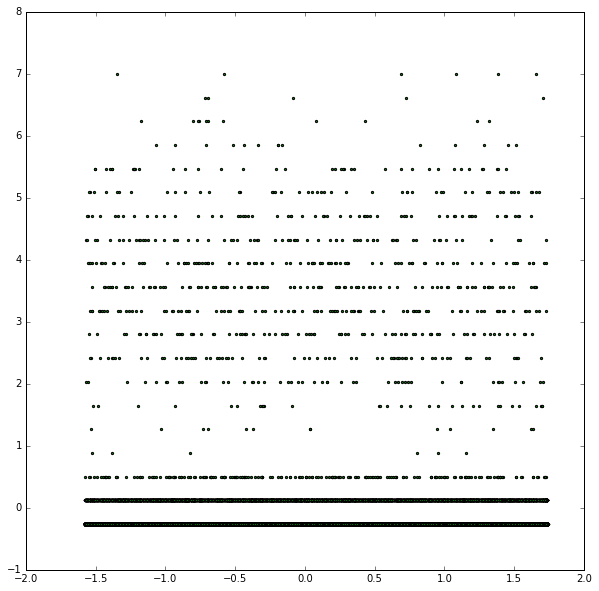

In [199]:
plt.figure(figsize=(10,10))
plt.scatter(x_scaled[np.array(y_array==0),1],x_scaled[np.array(y_array==0),0],c='g',s=5)

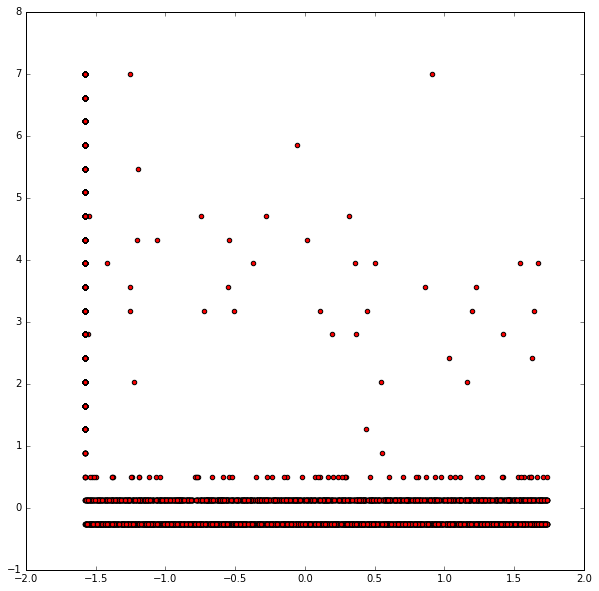

In [198]:
plt.figure(figsize=(10,10))
plt.scatter(x_scaled[np.array(y_array==1),1],x_scaled[np.array(y_array==1),0],c='r')

# Fitting the Whole Model

In [201]:
chosen_Lr.fit(x_array,y_array)
Rf_pred=chosen_Rf.predict(x_array)
print classification_report(y_array,Rf_pred)

             precision    recall  f1-score   support

          0       0.95      1.00      0.98    136961
          1       1.00      0.54      0.70     14151

avg / total       0.96      0.96      0.95    151112



# Let's optimize for Recall

In [219]:
Param_grid_Lr={"Scaler__with_std":[True,False],"LR__C":np.logspace(-5,5,11),"LR__penalty":['l2'],"LR__class_weight":["balanced"]}
best_Lr_recall=GridSearchCV(Pipe_Lr,Param_grid_Lr,cv=4,verbose=1,n_jobs=1,scoring='recall')
best_Lr_recall.fit(Train_X,Train_Y)

Fitting 4 folds for each of 22 candidates, totalling 88 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    9.9s
[Parallel(n_jobs=1)]: Done  88 out of  88 | elapsed:   18.6s finished


GridSearchCV(cv=4, error_score='raise',
       estimator=Pipeline(steps=[('Scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('LR', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=84, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'LR__penalty': ['l2'], 'LR__class_weight': ['balanced'], 'Scaler__with_std': [True, False], 'LR__C': array([  1.00000e-05,   1.00000e-04,   1.00000e-03,   1.00000e-02,
         1.00000e-01,   1.00000e+00,   1.00000e+01,   1.00000e+02,
         1.00000e+03,   1.00000e+04,   1.00000e+05])},
       pre_dispatch='2*n_jobs', refit=True, scoring='recall', verbose=1)

In [220]:
print best_Lr_recall.best_params_,best_Lr_recall.best_score_
chosen_Lr_recall=best_Lr_recall.best_estimator_
chosen_Lr_recall.fit(Train_X,Train_Y)
chosen_recall_train=chosen_Lr_recall.predict(Train_X)
chosen_recall_test=chosen_Lr_recall.predict(Test_X)
print classification_report(Test_y,chosen_recall_test)
print chosen_Lr_recall.named_steps["LR"].coef_

{'Scaler__with_std': True, 'LR__class_weight': 'balanced', 'LR__penalty': 'l2', 'LR__C': 100.0} 0.704889414604
             precision    recall  f1-score   support

          0       0.97      0.93      0.95     34240
          1       0.52      0.72      0.61      3538

avg / total       0.93      0.91      0.92     37778

[[ 2.65268725  0.00865098 -0.00641902]]


# Rf for Recall

In [223]:
Pipe_Rf=Pipeline([("Scaler",StandardScaler()),("Rf",RandomForestClassifier())])
Param_grid_Rf={"Scaler__with_std":[True],'Rf__n_estimators':[20],'Rf__min_samples_split':[650,800],\
                  'Rf__max_features':['auto'],'Rf__class_weight':['balanced',{0:1,1:1}]}
best_Rf_recall=GridSearchCV(Pipe_Rf,Param_grid_Rf,cv=4,verbose=1,n_jobs=1,scoring='recall')
best_Rf_recall.fit(Train_X,Train_Y)
print best_Rf_recall.best_params_,best_Rf_recall.best_score_,

Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:   57.0s finished


{'Scaler__with_std': True, 'Rf__min_samples_split': 800, 'Rf__n_estimators': 20, 'Rf__class_weight': 'balanced', 'Rf__max_features': 'auto'} 0.712804726776


In [224]:
chosen_Rf_recall=best_Rf_recall.best_estimator_
chosen_Rf_recall.fit(Train_X,Train_Y)
chosen_Rf_recall_train=chosen_Rf_recall.predict(Train_X)
chosen_Rf_recall_test=chosen_Rf_recall.predict(Test_X)


NameError: name 'chosen__Rf_recall_test' is not defined

In [226]:
print classification_report(Test_y,chosen_Rf_recall_test)
print chosen_Rf_recall.named_steps["Rf"].feature_importances_

             precision    recall  f1-score   support

          0       0.97      0.94      0.95     34240
          1       0.54      0.72      0.62      3538

avg / total       0.93      0.92      0.92     37778

[ 0.54659101  0.45191967  0.00148932]


In [229]:
from sklearn.metrics import accuracy_score,confusion_matrix

In [231]:
print accuracy_score(Test_y,chosen_Rf_recall_test)
print confusion_matrix(Test_y,chosen_Rf_recall_test)

0.91672401927
[[32099  2141]
 [ 1005  2533]]


# Testing Adaboost

In [232]:
from sklearn.ensemble import AdaBoostClassifier

In [241]:
Pipe_Ada=Pipeline([("Scaler",StandardScaler()),("Ada",AdaBoostClassifier(random_state=42))])
Param_grid_Ada={"Scaler__with_std":[True],"Ada__learning_rate":[1.0],"Ada__n_estimators":[50,30,20,10]}
best_Ada_recall=GridSearchCV(Pipe_Ada,Param_grid_Ada,cv=4,verbose=1,n_jobs=1,scoring='f1')
best_Ada_recall.fit(Train_X,Train_Y)
print best_Ada_recall.best_params_,best_Ada_recall.best_score_,

Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:   18.1s finished


{'Ada__learning_rate': 1.0, 'Scaler__with_std': True, 'Ada__n_estimators': 20} 0.700317965333


In [237]:
chosen_Ada_recall=best_Ada_recall.best_estimator_
chosen_Ada_recall.fit(Train_X,Train_Y)
chosen_Ada_recall_train=chosen_Ada_recall.predict(Train_X)
chosen_Ada_recall_test=chosen_Ada_recall.predict(Test_X)

In [238]:
print classification_report(Test_y,chosen_Ada_recall_test)

             precision    recall  f1-score   support

          0       0.95      1.00      0.98     34240
          1       1.00      0.53      0.69      3538

avg / total       0.96      0.96      0.95     37778



# Testing KNN Classifier

In [239]:
from sklearn.neighbors import KNeighborsClassifier

In [248]:
Pipe_KNN=Pipeline([("Scaler",StandardScaler()),("KNN",KNeighborsClassifier())])
Param_grid_KNN={"Scaler__with_std":[True],"KNN__n_neighbors":[3,5],"KNN__p":[1,2]}
best_KNN_recall=GridSearchCV(Pipe_KNN,Param_grid_KNN,cv=4,verbose=1,n_jobs=1,scoring='recall')
best_KNN_recall.fit(Train_X,Train_Y)
print best_KNN_recall.best_params_,best_KNN_recall.best_score_,

Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:  1.8min finished


{'KNN__p': 1, 'Scaler__with_std': True, 'KNN__n_neighbors': 3} 0.563648324704


In [249]:
chosen_KNN_recall=best_KNN_recall.best_estimator_
chosen_KNN_recall.fit(Train_X,Train_Y)
chosen_KNN_recall_train=chosen_KNN_recall.predict(Train_X)
chosen_KNN_recall_test=chosen_KNN_recall.predict(Test_X)
print classification_report(Test_y,chosen_KNN_recall_test)

             precision    recall  f1-score   support

          0       0.96      0.99      0.97     34240
          1       0.84      0.56      0.67      3538

avg / total       0.94      0.95      0.94     37778



# Lets redo things in a way that better simulates real-time data

## Reforming data frame by sorting things in order of purchase time and calculating variables only for time in the past

In [265]:
df2=df_original.copy()
df2["purchase_time"]=pd.to_datetime(df2["purchase_time"])
df2["signup_time"]=pd.to_datetime(df2["signup_time"])
df_sorted=df_original.sort_values("purchase_time")

In [288]:
df_sorted.head(n=20)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,Country,Country_mask,Source_Encoded,browser_encoded,sex_encoded,device use frequency,hours_to_purchase,hrs/use
0,309557,2015-01-01 00:00:43,2015-01-01 00:00:44,14,BBPACGBUVJUXF,Ads,Chrome,F,38,2.001426e+09,1,Korea Republic of,1,0,0,0,10,0.000278,0.000028
1,124539,2015-01-01 00:00:44,2015-01-01 00:00:45,14,BBPACGBUVJUXF,Ads,Chrome,F,38,2.001426e+09,1,Korea Republic of,1,0,0,0,10,0.000278,0.000028
2,161246,2015-01-01 00:00:45,2015-01-01 00:00:46,14,BBPACGBUVJUXF,Ads,Chrome,F,38,2.001426e+09,1,Korea Republic of,1,0,0,0,10,0.000278,0.000028
3,356414,2015-01-01 00:00:46,2015-01-01 00:00:47,14,BBPACGBUVJUXF,Ads,Chrome,F,38,2.001426e+09,1,Korea Republic of,1,0,0,0,10,0.000278,0.000028
4,338656,2015-01-01 00:00:47,2015-01-01 00:00:48,14,BBPACGBUVJUXF,Ads,Chrome,F,38,2.001426e+09,1,Korea Republic of,1,0,0,0,10,0.000278,0.000028
5,36229,2015-01-01 00:00:48,2015-01-01 00:00:49,14,BBPACGBUVJUXF,Ads,Chrome,F,38,2.001426e+09,1,Korea Republic of,1,0,0,0,10,0.000278,0.000028
6,143242,2015-01-01 00:00:49,2015-01-01 00:00:50,14,BBPACGBUVJUXF,Ads,Chrome,F,38,2.001426e+09,1,Korea Republic of,1,0,0,0,10,0.000278,0.000028
7,156748,2015-01-01 00:00:50,2015-01-01 00:00:51,14,BBPACGBUVJUXF,Ads,Chrome,F,38,2.001426e+09,1,Korea Republic of,1,0,0,0,10,0.000278,0.000028
8,145628,2015-01-01 00:00:51,2015-01-01 00:00:52,14,BBPACGBUVJUXF,Ads,Chrome,F,38,2.001426e+09,1,Korea Republic of,1,0,0,0,10,0.000278,0.000028
9,157926,2015-01-01 00:12:10,2015-01-01 00:12:11,63,DXWTAJVQOEZTC,SEO,Chrome,M,31,6.860829e+08,1,United States,0,2,0,1,11,0.000278,0.000025


In [296]:
fraud_series=[]
#for i in np.arange(np.arange(len(df_sorted))):
for i in np.arange((len(df_sorted))):
    temp=df_sorted.iloc[0:i+1]
    try:    
        fraud_series.append(temp[temp["device_id"]==df_sorted.iloc[i]["device_id"]]["class"].value_counts()[1])
    except KeyError:
        fraud_series.append(0)



KeyboardInterrupt: 

In [297]:
from tqdm import tqdm_notebook,tnrange
freq_series=[]
for i in tnrange(len(df_sorted)):
    temp=df_sorted.iloc[0:i+1]
    freq_series.append(len(temp[temp["device_id"]==df_sorted.iloc[i]["device_id"]]))
print freq_series



[1, 2, 3, 4, 5, 6, 7, 8, 9, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 1, 2, 3, 4, 5, 6, 7, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1, 2, 3, 4, 5, 6, 7, 8, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 1, 2, 3, 4, 5, 6, 7, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 1, 2, 3, 4, 5, 6, 7, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 1, 2, 3, 4, 5, 6, 1, 2, 3, 4, 5, 6, 7, 1, 2, 3, 4, 5, 6, 7, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 1, 2, 3, 4, 5, 6, 7, 8, 9, 1, 2, 3, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 1, 2, 3, 4, 5, 6, 7, 8, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 1, 2, 3, 4, 5, 6, 7, 8,

In [298]:
Counter(freq_series)

Counter({1: 137956,
         2: 6175,
         3: 848,
         4: 758,
         5: 754,
         6: 741,
         7: 712,
         8: 662,
         9: 593,
         10: 515,
         11: 423,
         12: 322,
         13: 232,
         14: 168,
         15: 111,
         16: 70,
         17: 34,
         18: 21,
         19: 11,
         20: 6})

In [299]:
df_sorted["Num_used"]=np.array(freq_series)

In [304]:
def plot_hist2(field_name,bins=50):
    args={"legend":True,"figsize":(8,8),"kind":"hist","title":"Probability Distribition for "+field_name,"bins":bins}
    #df_sorted[field_name][df_sorted["class"]==0].plot(label="Not Fraud",**args)
    df_sorted[field_name][df_sorted["class"]==1].plot(label="Fraud",**args)
    
def plot_kde2(field_name):
    args={"legend":True,"figsize":(8,8),"kind":"kde","title":"Probability Distribition for "+field_name}
    df_sorted[field_name][df_sorted["class"]==0].plot(label="Not Fraud",**args)
    df_sorted[field_name][df_sorted["class"]==1].plot(label="Fraud",**args)  

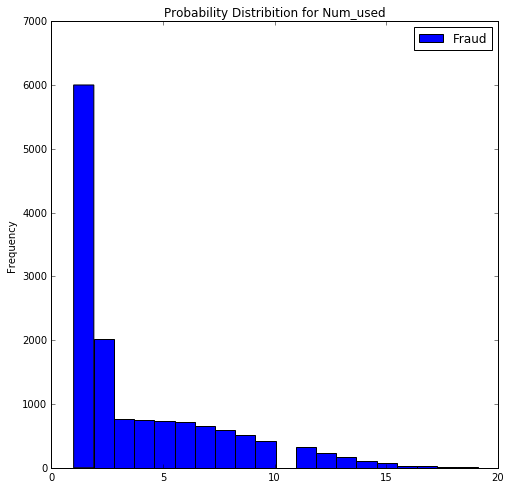

In [305]:
plot_hist2("Num_used",21)

In [375]:
def get_relative_amounts2(field_name):
    print "(Class Name)", "(Count)", "(Relative Probability of the Class)"
    for i in sorted(df_sorted[field_name].unique()) :
        print "For type {0}".format(i) 
        amt= df_sorted[df_sorted[field_name]==i]["class"].value_counts()
        for i in range(2):
            print i,amt.get(i,0),float(amt.get(i,0))/np.sum(amt.values)

In [303]:
get_relative_amounts2("Num_used")

(Class Name) (Count) (Relative Probability of the Class)
For type 1
0 131953 0.956486126011
1 6003 0.0435138739888
For type 2
0 4163 0.674170040486
1 2012 0.325829959514
For type 3
0 76 0.0896226415094
1 772 0.910377358491
For type 4
0 3 0.00395778364116
1 755 0.996042216359
For type 5
0 14 0.0185676392573
1 740 0.981432360743
For type 6
0 30 0.0404858299595
1 711 0.95951417004
For type 7
0 49 0.0688202247191
1 663 0.931179775281
For type 8
0 72 0.108761329305
1 590 0.891238670695
For type 9
0 79 0.133220910624
1 514 0.866779089376
For type 10
0 93 0.180582524272
1 422 0.819417475728
For type 11
0 99 0.234042553191
1 324 0.765957446809
For type 12
0 90 0.27950310559
1 232 0.72049689441
For type 13
0 65 0.280172413793
1 167 0.719827586207
For type 14
0 61 0.363095238095
1 107 0.636904761905
For type 15
0 43 0.387387387387
1 68 0.612612612613
For type 16
0 37 0.528571428571
1 33 0.471428571429
For type 17
0 13 0.382352941176
1 21 0.617647058824
For type 18
0 10 0.47619047619
1 11 0.52380

In [306]:
fraud_before=np.loadtxt("fraud_before.dat")

In [307]:
df_sorted["Fraud_before"]=fraud_before

In [372]:
age_before=np.loadtxt("age_series.dat")
df_sorted["Age Before"]=age_before

In [376]:
get_relative_amounts2("Fraud_before")

(Class Name) (Count) (Relative Probability of the Class)
For type 0.0
0 136183 0.95119787665
1 6987 0.0488021233499
For type 1.0
0 9 0.00854700854701
1 1044 0.991452991453
For type 2.0
0 3 0.00394736842105
1 757 0.996052631579
For type 3.0
0 15 0.0195058517555
1 754 0.980494148244
For type 4.0
0 30 0.038961038961
1 740 0.961038961039
For type 5.0
0 49 0.0644736842105
1 711 0.935526315789
For type 6.0
0 74 0.100407055631
1 663 0.899592944369
For type 7.0
0 79 0.117910447761
1 591 0.882089552239
For type 8.0
0 94 0.154351395731
1 515 0.845648604269
For type 9.0
0 96 0.185686653772
1 421 0.814313346228
For type 10.0
0 93 0.223021582734
1 324 0.776978417266
For type 11.0
0 65 0.219594594595
1 231 0.780405405405
For type 12.0
0 65 0.280172413793
1 167 0.719827586207
For type 13.0
0 37 0.256944444444
1 107 0.743055555556
For type 14.0
0 36 0.346153846154
1 68 0.653846153846
For type 15.0
0 13 0.276595744681
1 34 0.723404255319
For type 16.0
0 9 0.310344827586
1 20 0.689655172414
For type 17.

In [377]:
get_relative_amounts2("Age Before")

(Class Name) (Count) (Relative Probability of the Class)
For type 0.0
0 136081 0.949523776297
1 7234 0.050476223703
For type 1.0
0 153 0.160209424084
1 802 0.839790575916
For type 2.0
0 2 0.00263504611331
1 757 0.997364953887
For type 3.0
0 3 0.00396301188904
1 754 0.996036988111
For type 4.0
0 13 0.0172642762284
1 740 0.982735723772
For type 5.0
0 29 0.0391891891892
1 711 0.960810810811
For type 6.0
0 47 0.0661971830986
1 663 0.933802816901
For type 7.0
0 70 0.106060606061
1 590 0.893939393939
For type 8.0
0 76 0.128813559322
1 514 0.871186440678
For type 9.0
0 87 0.171597633136
1 420 0.828402366864
For type 10.0
0 94 0.224880382775
1 324 0.775119617225
For type 11.0
0 88 0.275862068966
1 231 0.724137931034
For type 12.0
0 60 0.264317180617
1 167 0.735682819383
For type 13.0
0 56 0.343558282209
1 107 0.656441717791
For type 14.0
0 36 0.346153846154
1 68 0.653846153846
For type 15.0
0 35 0.514705882353
1 33 0.485294117647
For type 16.0
0 12 0.375
1 20 0.625
For type 17.0
0 9 0.45
1 11 

In [378]:
df_sorted.to_csv("Sorted_df_new.df")

# Redoing Machine Learning For this scenario

## Lets start with Random Forests and optimize for f1 score.

In [380]:
Nto_keep=["Country_mask","device use frequency","Source_Encoded","browser_encoded","sex_encoded","hours_to_purchase","age","purchase_value","hrs/use","Fraud_before","Num_used","Age Before","class"]
Ndf_ml2=df_sorted[Nto_keep]

In [381]:
Nto_keep_ml=["Num_used","Fraud_before","hours_to_purchase","Country_mask","purchase_value","Age Before"]
Nx_array=Ndf_ml2[Nto_keep_ml].values
Ny_array=Ndf_ml2["class"]

In [382]:
NTrain_X,NTest_X,NTrain_Y,NTest_y=train_test_split(Nx_array,Ny_array,test_size=0.25,stratify=Ny_array,random_state=42)

In [383]:
NPipe_Rf=Pipeline([("Scaler",StandardScaler()),("Rf",RandomForestClassifier())])
NParam_grid_Rf={"Scaler__with_std":[False],'Rf__n_estimators':[25],'Rf__min_samples_split':[500],\
                  'Rf__max_features':['auto'],'Rf__class_weight':[{0:1,1:3},{0:1,1:2}]}
Nbest_Rf=GridSearchCV(NPipe_Rf,NParam_grid_Rf,cv=4,verbose=1,n_jobs=1,scoring='f1')
Nbest_Rf.fit(NTrain_X,NTrain_Y)
print Nbest_Rf.best_params_,Nbest_Rf.best_score_

Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   24.8s finished


{'Scaler__with_std': False, 'Rf__min_samples_split': 500, 'Rf__n_estimators': 25, 'Rf__class_weight': {0: 1, 1: 2}, 'Rf__max_features': 'auto'} 0.71523015082


In [384]:
Nchosen_Rf=Nbest_Rf.best_estimator_
Nchosen_Rf.fit(NTrain_X,NTrain_Y)
Nchosen_Rf_train=Nchosen_Rf.predict(NTrain_X)
Nchosen_Rf_test=Nchosen_Rf.predict(NTest_X)
print classification_report(NTest_y,Nchosen_Rf_test)

             precision    recall  f1-score   support

          0       0.96      1.00      0.98     34240
          1       1.00      0.55      0.71      3538

avg / total       0.96      0.96      0.95     37778



AUC for Random Forest=0.805098041854


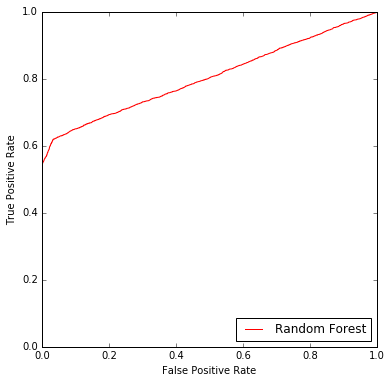

In [385]:
Ny_dec_func_Rf=Nchosen_Rf.predict_proba(NTest_X)[:,1]
fpr_Rf,tpr_Rf,thresholds_Rf=roc_curve(NTest_y,Ny_dec_func_Rf)

print "AUC for Random Forest={}".format(auc(fpr_Rf,tpr_Rf))

plt.figure(figsize=(6,6))
plt.plot(fpr_Rf, tpr_Rf,'r-',label="Random Forest")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.ylim([0,1])
plt.legend(loc=4)


## Illustrative example showing how we could optimize for recall instead to build a more conservative classifier

In this case we would increase the weight of the fraud class by a lot. The more you try to increase the weight, the more the classifier tries to avoid false negatives for the fraud class. Now this ofcourse leads to a lot of false positives as well, which lowers the precision. In the example below we have made the class weights 100:1 (this is ofcourse far too high but we are just trying to make a point) to illustrate this effect. As you can see, the recall is almost 1 now, but precision has majorly suffered.

In [391]:
NPipe_Rf_recall=Pipeline([("Scaler",StandardScaler()),("Rf",RandomForestClassifier())])
NParam_grid_Rf_recall={"Scaler__with_std":[False],'Rf__n_estimators':[25],'Rf__min_samples_split':[500],\
                  'Rf__max_features':['auto'],'Rf__class_weight':[{0:1,1:100}]}
Nbest_Rf_recall=GridSearchCV(NPipe_Rf_recall,NParam_grid_Rf_recall,cv=4,verbose=1,n_jobs=1,scoring='recall')
Nbest_Rf_recall.fit(NTrain_X,NTrain_Y)
print Nbest_Rf_recall.best_params_,Nbest_Rf_recall.best_score_

Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   13.3s finished


{'Scaler__with_std': False, 'Rf__min_samples_split': 500, 'Rf__n_estimators': 25, 'Rf__class_weight': {0: 1, 1: 100}, 'Rf__max_features': 'auto'} 0.992461843801


In [392]:
Nchosen_Rf_recall=Nbest_Rf_recall.best_estimator_
Nchosen_Rf_recall.fit(NTrain_X,NTrain_Y)
Nchosen_Rf_recall_train=Nchosen_Rf_recall.predict(NTrain_X)
Nchosen_Rf_recall_test=Nchosen_Rf_recall.predict(NTest_X)
print classification_report(NTest_y,Nchosen_Rf_recall_test)

             precision    recall  f1-score   support

          0       0.96      0.01      0.03     34240
          1       0.09      0.99      0.17      3538

avg / total       0.88      0.11      0.04     37778



# Testing out Logistic Regression (again optimizing for f1 score) 

In [389]:
NPipe_Lr=Pipeline([("Scaler",StandardScaler()),("LR",LogisticRegression(random_state=84))])
NParam_grid_Lr={"Scaler__with_std"
               :[True],"LR__C":List_C,"LR__penalty":['l1','l2'],"LR__class_weight":[{0:1,1:4},{0:1,1:5}]}
Nbest_Lr=GridSearchCV(NPipe_Lr,NParam_grid_Lr,cv=4,verbose=2,n_jobs=1,scoring='f1')
Nbest_Lr.fit(NTrain_X,NTrain_Y)
print Nbest_Lr.best_params_,Nbest_Lr.best_score_

Fitting 4 folds for each of 44 candidates, totalling 176 fits
[CV] Scaler__with_std=True, LR__class_weight={0: 1, 1: 4}, LR__penalty=l1, LR__C=1e-05 
[CV]  Scaler__with_std=True, LR__class_weight={0: 1, 1: 4}, LR__penalty=l1, LR__C=1e-05 -   0.1s
[CV] Scaler__with_std=True, LR__class_weight={0: 1, 1: 4}, LR__penalty=l1, LR__C=1e-05 
[CV]  Scaler__with_std=True, LR__class_weight={0: 1, 1: 4}, LR__penalty=l1, LR__C=1e-05 -   0.1s
[CV] Scaler__with_std=True, LR__class_weight={0: 1, 1: 4}, LR__penalty=l1, LR__C=1e-05 
[CV]  Scaler__with_std=True, LR__class_weight={0: 1, 1: 4}, LR__penalty=l1, LR__C=1e-05 -   0.1s
[CV] Scaler__with_std=True, LR__class_weight={0: 1, 1: 4}, LR__penalty=l1, LR__C=1e-05 
[CV]  Scaler__with_std=True, LR__class_weight={0: 1, 1: 4}, LR__penalty=l1, LR__C=1e-05 -   0.1s
[CV] Scaler__with_std=True, LR__class_weight={0: 1, 1: 4}, LR__penalty=l2, LR__C=1e-05 
[CV]  Scaler__with_std=True, LR__class_weight={0: 1, 1: 4}, LR__penalty=l2, LR__C=1e-05 -   0.1s
[CV] Scaler__

[Parallel(n_jobs=1)]: Done  40 tasks       | elapsed:    8.1s


[CV]  Scaler__with_std=True, LR__class_weight={0: 1, 1: 5}, LR__penalty=l1, LR__C=0.001 -   0.2s
[CV] Scaler__with_std=True, LR__class_weight={0: 1, 1: 5}, LR__penalty=l1, LR__C=0.001 
[CV]  Scaler__with_std=True, LR__class_weight={0: 1, 1: 5}, LR__penalty=l1, LR__C=0.001 -   0.2s
[CV] Scaler__with_std=True, LR__class_weight={0: 1, 1: 5}, LR__penalty=l1, LR__C=0.001 
[CV]  Scaler__with_std=True, LR__class_weight={0: 1, 1: 5}, LR__penalty=l1, LR__C=0.001 -   0.2s
[CV] Scaler__with_std=True, LR__class_weight={0: 1, 1: 5}, LR__penalty=l1, LR__C=0.001 
[CV]  Scaler__with_std=True, LR__class_weight={0: 1, 1: 5}, LR__penalty=l1, LR__C=0.001 -   0.2s
[CV] Scaler__with_std=True, LR__class_weight={0: 1, 1: 5}, LR__penalty=l2, LR__C=0.001 
[CV]  Scaler__with_std=True, LR__class_weight={0: 1, 1: 5}, LR__penalty=l2, LR__C=0.001 -   0.2s
[CV] Scaler__with_std=True, LR__class_weight={0: 1, 1: 5}, LR__penalty=l2, LR__C=0.001 
[CV]  Scaler__with_std=True, LR__class_weight={0: 1, 1: 5}, LR__penalty=l2,

[Parallel(n_jobs=1)]: Done 161 tasks       | elapsed:  4.9min


[CV]  Scaler__with_std=True, LR__class_weight={0: 1, 1: 4}, LR__penalty=l1, LR__C=100000.0 -   5.3s
[CV] Scaler__with_std=True, LR__class_weight={0: 1, 1: 4}, LR__penalty=l1, LR__C=100000.0 
[CV]  Scaler__with_std=True, LR__class_weight={0: 1, 1: 4}, LR__penalty=l1, LR__C=100000.0 -   6.1s
[CV] Scaler__with_std=True, LR__class_weight={0: 1, 1: 4}, LR__penalty=l1, LR__C=100000.0 
[CV]  Scaler__with_std=True, LR__class_weight={0: 1, 1: 4}, LR__penalty=l1, LR__C=100000.0 -   4.6s
[CV] Scaler__with_std=True, LR__class_weight={0: 1, 1: 4}, LR__penalty=l2, LR__C=100000.0 
[CV]  Scaler__with_std=True, LR__class_weight={0: 1, 1: 4}, LR__penalty=l2, LR__C=100000.0 -   0.3s
[CV] Scaler__with_std=True, LR__class_weight={0: 1, 1: 4}, LR__penalty=l2, LR__C=100000.0 
[CV]  Scaler__with_std=True, LR__class_weight={0: 1, 1: 4}, LR__penalty=l2, LR__C=100000.0 -   0.3s
[CV] Scaler__with_std=True, LR__class_weight={0: 1, 1: 4}, LR__penalty=l2, LR__C=100000.0 
[CV]  Scaler__with_std=True, LR__class_weight

[Parallel(n_jobs=1)]: Done 176 out of 176 | elapsed:  5.5min finished


In [390]:
Nchosen_Lr=Nbest_Lr.best_estimator_
Nchosen_Lr.fit(NTrain_X,NTrain_Y)
Nchosen_Lr_train=Nchosen_Lr.predict(NTrain_X)
Nchosen_Lr_test=Nchosen_Lr.predict(NTest_X)
print classification_report(NTest_y,Nchosen_Lr_test)

             precision    recall  f1-score   support

          0       0.95      0.99      0.97     34240
          1       0.89      0.48      0.62      3538

avg / total       0.94      0.95      0.94     37778

